# ***Introduction***

Retrieval-augmented generation (RAG) is an innovative approach in the field of natural language processing (NLP) that combines the strengths of retrieval-based and generation-based models to enhance the quality of generated text.

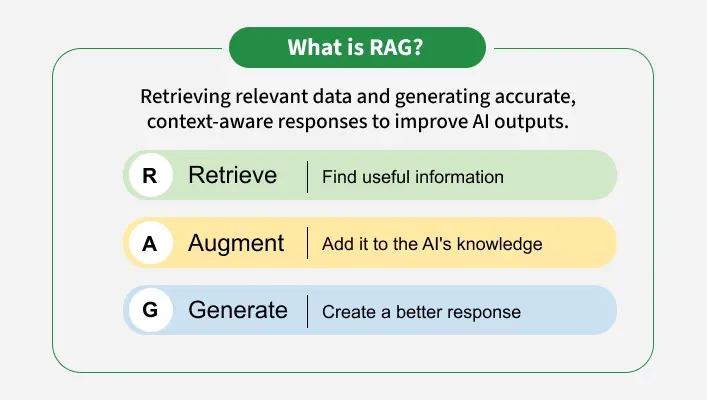

# ***How does Retrieval-Augmented Generation work?***

The system first searches external sources for relevant information based on the user’s query Instead of relying only on existing training data.

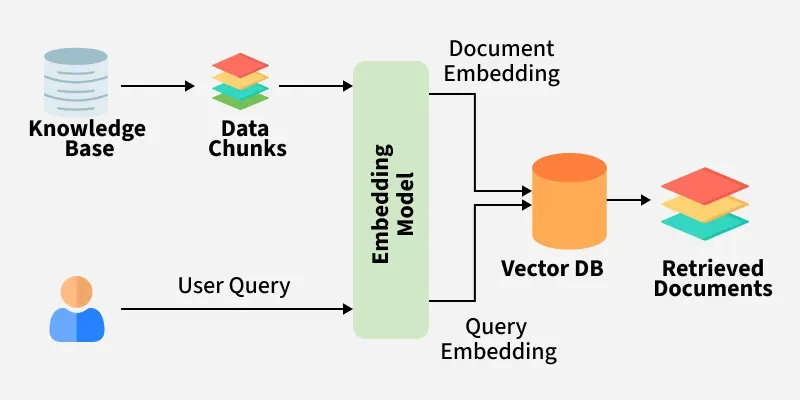

Source : [Geeksforgeeks](https://www.geeksforgeeks.org/nlp/what-is-retrieval-augmented-generation-rag/)

# 1. Installing Required Packages

In [10]:
# Install required packages
!pip install langchain langchain-openai openai pinecone-client tiktoken langchain-pinecone langchain_community pypdf

# 2. Importing Required Libraries and Configuring API Keys
From Langchain we have imported libraries that are essential for building  RAG (Retrieval Augmented Generation) QA Bot.

- `os` and `google.colab.userdata` handle secure API key management.

- `langchain_openai` provides the LLM (`ChatOpenAI`) and embedding model (`OpenAIEmbeddings`).

- `pinecone` and `langchain_pinecone` facilitate interaction with our Pinecone vector database for efficient document retrieval.

- Finally, `langchain.prompts.PromptTemplate` helps structure LLM prompts and `langchain.chains.RetrievalQA` orchestrates the entire RAG workflow to generate answers based on retrieved information.

We have to put our OPENAI API KEY and PINECONE API KEY like this as shown below:
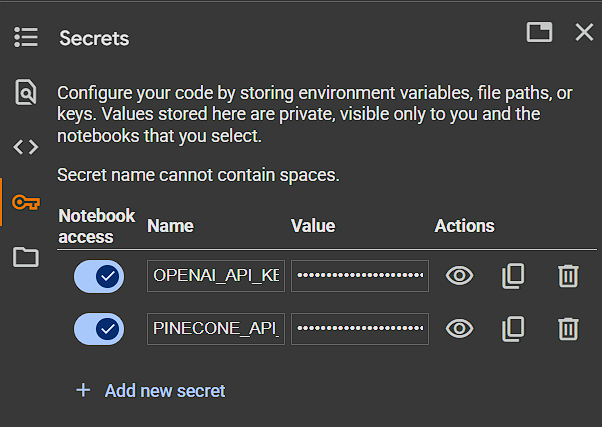

In [11]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from pinecone import Pinecone, ServerlessSpec
from google.colab import userdata


# --- Step 2: Configure API Keys and Environment ---

# A. Load keys from Colab Secrets
try:
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')

    # B. Set the loaded keys as environment variables
    os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
    os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

    print("API keys loaded and environment variables set successfully.")
    print("You can now proceed to the next steps.")

except Exception as e:
    print(f"Error loading API keys.")
    print("Please double-check that you have correctly saved 'OPEN_AI_API_KEY' and 'PINECONE_API_KEY' in Colab's Secrets manager (key icon on the left).")

API keys loaded and environment variables set successfully.
You can now proceed to the next steps.


# 3. Creating a sample business database

I took 'About Us' data from [TCS Official Website ](https://www.tcs.com/who-we-are). Created a PDF named TCS Information Data.pdf or we can directly put the data into double quotes "..." also instead of importing a pdf file.

PINECONE_INDEX_NAME : is an unique identifier for our vector database.

You can upload any text data about a specific company.

This scripts can load any pdf that have extractable text, convert it into chunks and generate embeddings.

In [16]:
# --- Add this import if you don't have it already for PDF loading ---
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter # For chunking
from pinecone import Pinecone, ServerlessSpec # Import Pinecone and ServerlessSpec

# Define your Pinecone index name (ensure it's consistent if already used)
PINECONE_INDEX_NAME = "business-qa-rag" # Or your preferred index name

# --- Load the PDF Document ---
# Ensure "TCS Information Data.pdf" is uploaded to your Colab session.
pdf_path = "/content/TCS Information Data.pdf"
documents = None # Initialize documents to None

try:
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    print(f"Successfully loaded {len(documents)} pages/documents from '{pdf_path}'.")
except FileNotFoundError:
    print(f"Error: The PDF file was not found at '{pdf_path}'. Please ensure it is uploaded to Colab and the path is correct.")
    # Consider what you want to do if the file isn't found (e.g., exit or skip PDF processing)
    # For a full notebook, you might just print the error and continue other parts if desired.
except Exception as e:
    print(f"An error occurred while loading the PDF: {e}")
    # Handle other exceptions

# ---  Split Documents into Chunks ---
# Only proceed if documents were loaded successfully
if documents is not None:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split document into {len(chunks)} chunks.")

    # --- Generate Embeddings (Ensure embeddings object is defined if not already) ---
    embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY, model="text-embedding-ada-002")
    embedding_dimension = 1536 # For text-embedding-ada-002

else:
    print("Skipping document splitting and upserting due to PDF loading error.")

Successfully loaded 2 pages/documents from '/content/TCS Information Data.pdf'.
Split document into 6 chunks.


# 4. Connecting to Pinecone Index

In this step we initialize pinecone and upsert the chunks to our Pinecone index.

'cosine' is the similarity metric used to compare vectors when searching.

'aws' as the cloud provider

In [17]:
    # --- Initialize Pinecone and Create/Connect to Index ---
    pc = Pinecone(api_key=PINECONE_API_KEY)

    if PINECONE_INDEX_NAME not in pc.list_indexes().names():
        print(f"Creating Pinecone index: {PINECONE_INDEX_NAME}...")
        pc.create_index(
            name=PINECONE_INDEX_NAME,
            dimension=embedding_dimension,
            metric='cosine',
            spec=ServerlessSpec(cloud='aws', region='us-west-2') # Adjust cloud/region
        )
        print(f"Index '{PINECONE_INDEX_NAME}' created.")
    else:
        print(f"Connecting to existing Pinecone index: {PINECONE_INDEX_NAME}.")

    # ---Upsert Chunks to Pinecone ---
    vectorstore = PineconeVectorStore.from_documents(
        chunks,
        embeddings,
        index_name=PINECONE_INDEX_NAME
    )
    print(f"Successfully upserted {len(chunks)} chunks to Pinecone index '{PINECONE_INDEX_NAME}'.")


Connecting to existing Pinecone index: business-qa-rag.
Successfully upserted 6 chunks to Pinecone index 'business-qa-rag'.


# 5. Choosing the LLM from OpenAI

The reason I chose 'gpt-4o-mini' because it is good for Lightweight applications, startups or projects with tight budgets.

Pros: Highly affordable while offering reasonable performance.

Cons: Limited capabilities compared to full-scale models.

We can also use other models like 'gpt-4o' (Omni) and 'gpt-3.5-turbo'
 which are very good for tasks like this.

In [18]:
# Initialize the Large Language Model (LLM) from OpenAI
llm = ChatOpenAI(
    model_name='gpt-4o-mini',
    temperature=0.0 # Set to 0 for factual, deterministic answers
)

# Create a retriever object from our vector store
# This object knows how to fetch relevant documents for a given query
retriever = vectorstore.as_retriever(search_kwargs={'k': 2}) # Retrieve the top 2 most relevant documents

# Create the RetrievalQA chain
# This chain combines the retriever and the LLM
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff", # "stuff" means all retrieved docs are stuffed into the prompt
    retriever=retriever
)

# 6. ChatBot

A simple iterative QA bot which retrives answer from the pinecone vector database that we uploaded above. The answers are pretty accurate and this model with training on large data will work very effectively and efficiently.

In [19]:
print("Welcome to the Business QA Bot!")
print("Ask me anything about TCS, or type 'exit' to quit.")

while True:
    user_query = input("\nYour question: ").strip() # .strip() removes leading/trailing whitespace

    if user_query.lower() in ["exit", "quit"]:
        print("Thank you for using the QA Bot. Goodbye!")
        break

    if not user_query: # Handle empty input
        print("Please enter a question.")
        continue

    try:
        # Invoke the QA chain with the user's query
        response = qa_chain.invoke({"query": user_query})

        # Print the answer
        print(f"\nAnswer: {response['result']}")

        # Optionally, print the source documents for transparency
        if 'source_documents' in response and response['source_documents']:
            print("\nSource Documents Retrieved:")
            for i, doc in enumerate(response['source_documents']):
                # Displaying a snippet of the page_content and the page number
                print(f"  --- Document {i+1} (Page: {doc.metadata.get('page', 'N/A')}) ---")
                print(f"{doc.page_content[:500]}...") # Print first 500 characters of the source
                print("-" * 30) # Separator for readability


    except Exception as e:
        print(f"An error occurred while processing your question: {e}")
        print("Please try again or recheck your setup.")

Welcome to the Business QA Bot!
Ask me anything about TCS, or type 'exit' to quit.

Your question: 
Please enter a question.

Your question: When was TCS found?

Answer: TCS was founded in 1968.

Your question: Who founded TCS?

Answer: TCS (Tata Consultancy Services) was founded by the Tata Group, with Fakir Chand Kohli as its first CEO.

Your question: Which company did TCS surpass in 2011?

Answer: TCS surpassed Accenture in market capitalization in October 2020. There is no mention of TCS surpassing any specific company in 2011.

Your question: what was the turnover bakc then?

Answer: I don't know.

Your question: quit
Thank you for using the QA Bot. Goodbye!
